In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
from timm.data.mixup import Mixup
from timm.loss import SoftTargetCrossEntropy
from timm.models.mobilevit import mobilevit_s
from apex import amp
import warnings
import json
warnings.filterwarnings("ignore")
import time
import os
import torch
import torch.nn.functional as F
import torchvision.models as models
from einops import rearrange
from torch import nn
from torch.utils.data import random_split

In [2]:
# 设置全局参数
model_lr = 1e-4
BATCH_SIZE = 32
EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
use_amp=False #是否使用混合精度
classes=4
CLIP_GRAD=5.0
# 数据预处理7

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()

])
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
mixup_fn = Mixup(
    mixup_alpha=0.8, cutmix_alpha=1.0, cutmix_minmax=None,
    prob=0.1, switch_prob=0.5, mode='batch',
    label_smoothing=0.1, num_classes=classes)

In [4]:
# 读取数据
dataset_train = datasets.ImageFolder('class/train', transform=transform)
dataset_test = datasets.ImageFolder("class/val", transform=transform_test)
# 导入数据
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)
print(dataset_train.class_to_idx)
with open('class.txt','w') as file:
    file.write(str(dataset_train.class_to_idx))
with open('class.json','w',encoding='utf-8') as file:
    file.write(json.dumps(dataset_train.class_to_idx))

{'Harmful': 0, 'Kitchen': 1, 'Other': 2, 'Recyclable': 3}


In [3]:
def _make_divisible(v, divisor, min_value=None):
	if min_value is None:
		min_value = divisor
	new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
	# Make sure that round down does not go down by more than 10%.
	if new_v < 0.9 * v:
		new_v += divisor
	return new_v


def Conv_BN_ReLU(inp, oup, kernel, stride=1):
	return nn.Sequential(
		nn.Conv2d(inp, oup, kernel_size=kernel, stride=stride, padding=1, bias=False),
		nn.BatchNorm2d(oup),
		nn.ReLU6(inplace=True)
	)


def conv_1x1_bn(inp, oup):
	return nn.Sequential(
		nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
		nn.BatchNorm2d(oup),
		nn.ReLU6(inplace=True)
	)


class PreNorm(nn.Module):
	def __init__(self, dim, fn):
		super().__init__()
		self.norm = nn.LayerNorm(dim)
		self.fn = fn

	def forward(self, x, **kwargs):
		return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
	def __init__(self, dim, hidden_dim, dropout=0.):
		super().__init__()
		self.ffn = nn.Sequential(
			nn.Linear(dim, hidden_dim),
			nn.SiLU(),
			nn.Dropout(dropout),
			nn.Linear(hidden_dim, dim),
			nn.Dropout(dropout)
		)

	def forward(self, x):
		return self.ffn(x)


class Attention(nn.Module):
	def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
		super().__init__()
		inner_dim = dim_head * heads
		project_out = not (heads == 1 and dim_head == dim)

		self.heads = heads
		self.scale = dim_head ** -0.5

		self.attend = nn.Softmax(dim=-1)
		self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

		self.to_out = nn.Sequential(
			nn.Linear(inner_dim, dim),
			nn.Dropout(dropout)
		) if project_out else nn.Identity()

	def forward(self, x):
		qkv = self.to_qkv(x).chunk(3, dim=-1)
		q, k, v = map(lambda t: rearrange(t, 'b p n (h d) -> b p h n d', h=self.heads), qkv)

		dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
		attn = self.attend(dots)
		out = torch.matmul(attn, v)
		out = rearrange(out, 'b p h n d -> b p n (h d)')
		return self.to_out(out)


class Transformer(nn.Module):
	def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
		super().__init__()
		self.layers = nn.ModuleList([])
		for _ in range(depth):
			self.layers.append(nn.ModuleList([
				PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
				PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
			]))

	def forward(self, x):
		for attn, ff in self.layers:
			x = attn(x) + x
			x = ff(x) + x
		return x


class MV2Block(nn.Module):
	def __init__(self, inp, oup, stride=1, expand_ratio=4):
		super(MV2Block, self).__init__()
		assert stride in [1, 2]

		hidden_dim = round(inp * expand_ratio)
		self.identity = stride == 1 and inp == oup

		if expand_ratio == 1:
			self.conv = nn.Sequential(
				# dw
				nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
				nn.BatchNorm2d(hidden_dim),
				# nn.ReLU6(inplace=True),
				nn.SiLU(),
				# pw-linear
				nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
				nn.BatchNorm2d(oup),
			)
		else:
			self.conv = nn.Sequential(
				# pw
				nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
				nn.BatchNorm2d(hidden_dim),
				# nn.ReLU6(inplace=True),
				nn.SiLU(),
				# dw
				nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
				nn.BatchNorm2d(hidden_dim),
				# nn.ReLU6(inplace=True),
				nn.SiLU(),
				# pw-linear
				nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
				nn.BatchNorm2d(oup),
			)

	def forward(self, x):
		if self.identity:
			return x + self.conv(x)
		else:
			return self.conv(x)


class MobileViTBlock(nn.Module):
	def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
		super().__init__()
		self.ph, self.pw = patch_size

		self.conv1 = Conv_BN_ReLU(channel, channel, kernel_size)
		self.conv2 = conv_1x1_bn(channel, dim)

		self.transformer = Transformer(dim, depth, 1, 32, mlp_dim, dropout)

		self.conv3 = conv_1x1_bn(dim, channel)
		self.conv4 = Conv_BN_ReLU(2 * channel, channel, kernel_size)

	def forward(self, x):
		y = x.clone()

		# Local representations
		x = self.conv1(x)
		x = self.conv2(x)

		# Global representations
		_, _, h, w = x.shape
		x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d', ph=self.ph, pw=self.pw)
		x = self.transformer(x)
		x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)', h=h // self.ph, w=w // self.pw, ph=self.ph,
		              pw=self.pw)

		# Fusion
		x = self.conv3(x)
		x = torch.cat((x, y), 1)
		x = self.conv4(x)
		return x


class MobileVit(nn.Module):
	def __init__(self, image_size, dims, channels, num_classes, expansion=4, kernel_size=3, patch_size=(2, 2)):
		super().__init__()
		ih, iw = image_size
		ph, pw = patch_size
		assert ih % ph == 0 and iw % pw == 0

		L = [2, 4, 3]

		self.conv1 = Conv_BN_ReLU(3, channels[0], kernel=3, stride=2)

		self.mv2 = nn.ModuleList([])
		self.mv2.append(MV2Block(channels[0], channels[1], 1, expansion))
		self.mv2.append(MV2Block(channels[1], channels[2], 2, expansion))
		self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))
		self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))  # Repeat
		self.mv2.append(MV2Block(channels[3], channels[4], 2, expansion))
		self.mv2.append(MV2Block(channels[5], channels[6], 2, expansion))
		self.mv2.append(MV2Block(channels[7], channels[8], 2, expansion))

		self.mvit = nn.ModuleList([])
		self.mvit.append(MobileViTBlock(dims[0], L[0], channels[5], kernel_size, patch_size, int(dims[0] * 2)))
		self.mvit.append(MobileViTBlock(dims[1], L[1], channels[7], kernel_size, patch_size, int(dims[1] * 4)))
		self.mvit.append(MobileViTBlock(dims[2], L[2], channels[9], kernel_size, patch_size, int(dims[2] * 4)))

		self.conv2 = conv_1x1_bn(channels[-2], channels[-1])

		self.pool = nn.AvgPool2d(ih // 32, 1)
		self.fc = nn.Linear(channels[-1], num_classes, bias=False)

	def forward(self, x):
		x = self.conv1(x)
		x = self.mv2[0](x)

		x = self.mv2[1](x)
		x = self.mv2[2](x)
		x = self.mv2[3](x)  # Repeat

		x = self.mv2[4](x)
		x = self.mvit[0](x)

		x = self.mv2[5](x)
		x = self.mvit[1](x)

		x = self.mv2[6](x)
		x = self.mvit[2](x)
		x = self.conv2(x)

		x = self.pool(x).view(-1, x.shape[1])
		x = self.fc(x)
		return x


def mobilevit_xxs():
	dims = [64, 80, 96]
	channels = [16, 16, 24, 24, 48, 48, 64, 64, 80, 80, 320]
	return MobileVit((256, 256), dims, channels, num_classes=1000, expansion=2)


def mobilevit_xs():
	dims = [96, 120, 144]
	channels = [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384]
	return MobileVit((256, 256), dims, channels, num_classes=1000)


def mobilevit_s():
	dims = [144, 192, 240]
	channels = [16, 32, 64, 64, 96, 96, 128, 128, 160, 160, 640]
	return MobileVit((256, 256), dims, channels, num_classes=4)

In [6]:
# 实例化模型并且移动到GPU
criterion_train = SoftTargetCrossEntropy()# 训练用的loss
criterion_val = torch.nn.CrossEntropyLoss()# 验证用的loss
model_ft = mobilevit_s()# 定义模型，并设置预训练# 修改类别
model_ft.to(DEVICE)
# 选择简单暴力的Adam优化器，学习率调低
optimizer = optim.Adam(model_ft.parameters(), lr=model_lr)
cosine_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=20, eta_min=1e-6)# 使用余弦退火算法调整学习率
if use_amp: #如果使用混合精度训练，则初始化amp。
    model, optimizer = amp.initialize(model_ft, optimizer, opt_level="O1") # 这里是“欧一”，不是“零一”
if torch.cuda.device_count() > 1: #检测是否存在多张显卡，如果存在则使用DP的方式并行训练
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_ft = torch.nn.DataParallel(model_ft)

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    sum_loss = 0
    total_num = len(train_loader.dataset)
    print(total_num, len(train_loader))
    for batch_idx, (data, target) in enumerate(train_loader):
        if len(data) % 2 != 0:
            if len(data) < 2:
                continue
            data = data[0:len(data) - 1]
            target = target[0:len(target) - 1]
            print(len(data))
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        samples, targets = mixup_fn(data, target)
        output = model(data)
        loss = criterion_train(output, targets)
        optimizer.zero_grad()
        if use_amp:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), CLIP_GRAD)
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD)
        optimizer.step()
        lr = optimizer.state_dict()['param_groups'][0]['lr']
        print_loss = loss.data.item()
        sum_loss += print_loss
        if (batch_idx + 1) % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLR:{:.9f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                       100. * (batch_idx + 1) / len(train_loader), loss.item(), lr))
    ave_loss = sum_loss / len(train_loader)
    print('epoch:{},loss:{}'.format(epoch, ave_loss))

In [8]:
ACC = 0

In [9]:
# 验证过程
def val(model, device, test_loader):
    global ACC
    model.eval()
    test_loss = 0
    correct = 0
    total_num = len(test_loader.dataset)
    print(total_num, len(test_loader))
    val_list = []
    pred_list = []
    with torch.no_grad():
        for data, target in test_loader:
            for t in target:
                val_list.append(t.data.item())
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion_val(output, target)
            _, pred = torch.max(output.data, 1)
            for p in pred:
                pred_list.append(p.data.item())
            correct += torch.sum(pred == target)
            print_loss = loss.data.item()
            test_loss += print_loss
        correct = correct.data.item()
        acc = correct / total_num
        avgloss = test_loss / len(test_loader)
        print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            avgloss, correct, len(test_loader.dataset), 100 * acc))
        if acc > ACC:
            if isinstance(model, torch.nn.DataParallel):
                torch.save(model.module, 'model_m' + str(epoch) + '_' + str(round(acc, 3)) + '.pth')
            else:
                torch.save(model, 'model_m' + str(epoch) + '_' + str(round(acc, 3)) + '.pth')
            ACC = acc
    return val_list, pred_list

In [10]:
# 训练
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
is_set_lr = False
for epoch in range(1, EPOCHS + 1):
    since = time.time()
    train(model_ft, DEVICE, train_loader, optimizer, epoch)
    if epoch < 600:
        cosine_schedule.step()
    else:
        if is_set_lr:
            continue
        for param_group in optimizer.param_groups:
            param_group["lr"] = 1e-6
            is_set_lr = True
    val_list, pred_list = val(model_ft, DEVICE, test_loader)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print(classification_report(val_list, pred_list, target_names=dataset_train.class_to_idx))

52303 1635
Train Epoch: 1 [320/52303 (1%)]	Loss: 1.317717	LR:0.000100000
Train Epoch: 1 [640/52303 (1%)]	Loss: 1.165151	LR:0.000100000
Train Epoch: 1 [960/52303 (2%)]	Loss: 1.058882	LR:0.000100000
Train Epoch: 1 [1280/52303 (2%)]	Loss: 1.103671	LR:0.000100000
Train Epoch: 1 [1600/52303 (3%)]	Loss: 1.062190	LR:0.000100000
Train Epoch: 1 [1920/52303 (4%)]	Loss: 1.048050	LR:0.000100000
Train Epoch: 1 [2240/52303 (4%)]	Loss: 1.019583	LR:0.000100000
Train Epoch: 1 [2560/52303 (5%)]	Loss: 0.970931	LR:0.000100000
Train Epoch: 1 [2880/52303 (6%)]	Loss: 0.843357	LR:0.000100000
Train Epoch: 1 [3200/52303 (6%)]	Loss: 0.878312	LR:0.000100000
Train Epoch: 1 [3520/52303 (7%)]	Loss: 1.092854	LR:0.000100000
Train Epoch: 1 [3840/52303 (7%)]	Loss: 0.934244	LR:0.000100000
Train Epoch: 1 [4160/52303 (8%)]	Loss: 0.768019	LR:0.000100000
Train Epoch: 1 [4480/52303 (9%)]	Loss: 0.856576	LR:0.000100000
Train Epoch: 1 [4800/52303 (9%)]	Loss: 0.881619	LR:0.000100000
Train Epoch: 1 [5120/52303 (10%)]	Loss: 0.89437

KeyboardInterrupt: 

Text(0.5, 1.0, 'Image Name:kichen,predict:Kitchen')

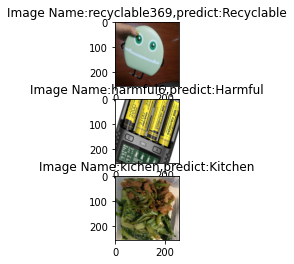

In [25]:
import torch.utils.data.distributed
import torchvision.transforms as transforms
from PIL import Image
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
classes = ('Harmful','Kitchen','Other','Recyclable')
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load("model_1_1.0 (1).pth",map_location='cpu')
model.eval()
model.to(DEVICE)

img = Image.open('garbage/recyclable369.jpg')
img = transform_test(img)
plt.subplot(311)
plt.imshow(img.permute(1, 2, 0));
img.unsqueeze_(0)
img = Variable(img).to(DEVICE)
out = model(img)
# Predict
_, pred = torch.max(out.data, 1)
a='Image Name:{},predict:{}'.format('recyclable369', classes[pred.data.item()])
plt.title('Image Name:{},predict:{}'.format('recyclable369', classes[pred.data.item()]))
img = Image.open('garbage/harmful6.jpg')
img = transform_test(img)
plt.subplot(312)
plt.imshow(img.permute(1, 2, 0));
img.unsqueeze_(0)
img = Variable(img).to(DEVICE)
out = model(img)
# Predict
_, pred = torch.max(out.data, 1)
b='Image Name:{},predict:{}'.format('harmful6', classes[pred.data.item()])
plt.title('Image Name:{},predict:{}'.format('harmful6', classes[pred.data.item()]))
img = Image.open('garbage/kichen.jpg')
img = transform_test(img)
plt.subplot(313)
plt.imshow(img.permute(1, 2, 0));

img.unsqueeze_(0)
img = Variable(img).to(DEVICE)
out = model(img)
# Predict
_, pred = torch.max(out.data, 1)
c='Image Name:{},predict:{}'.format('kichen', classes[pred.data.item()])
plt.title('Image Name:{},predict:{}'.format('kichen', classes[pred.data.item()]))


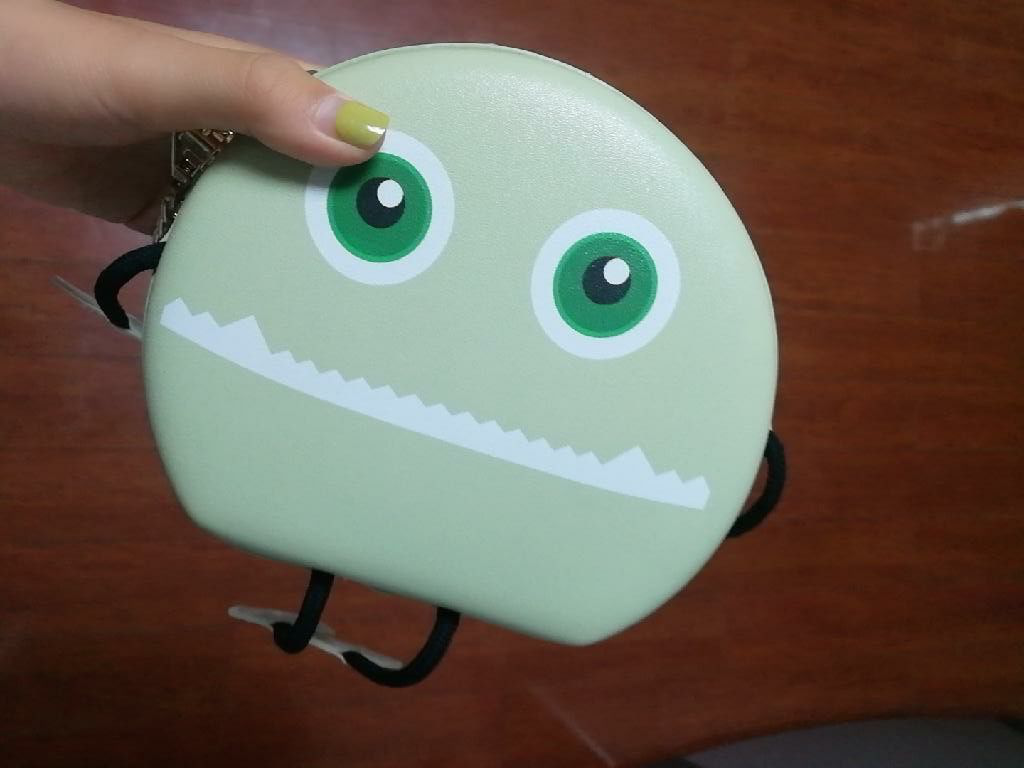
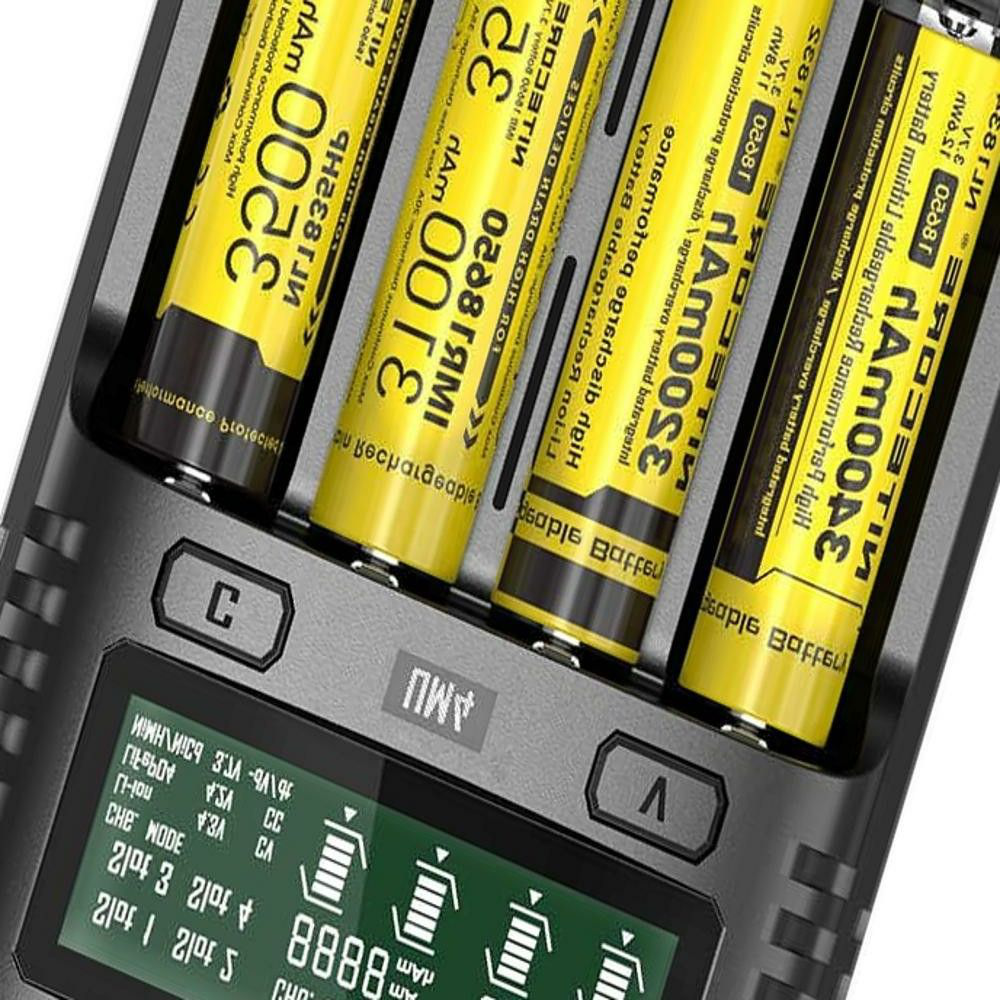
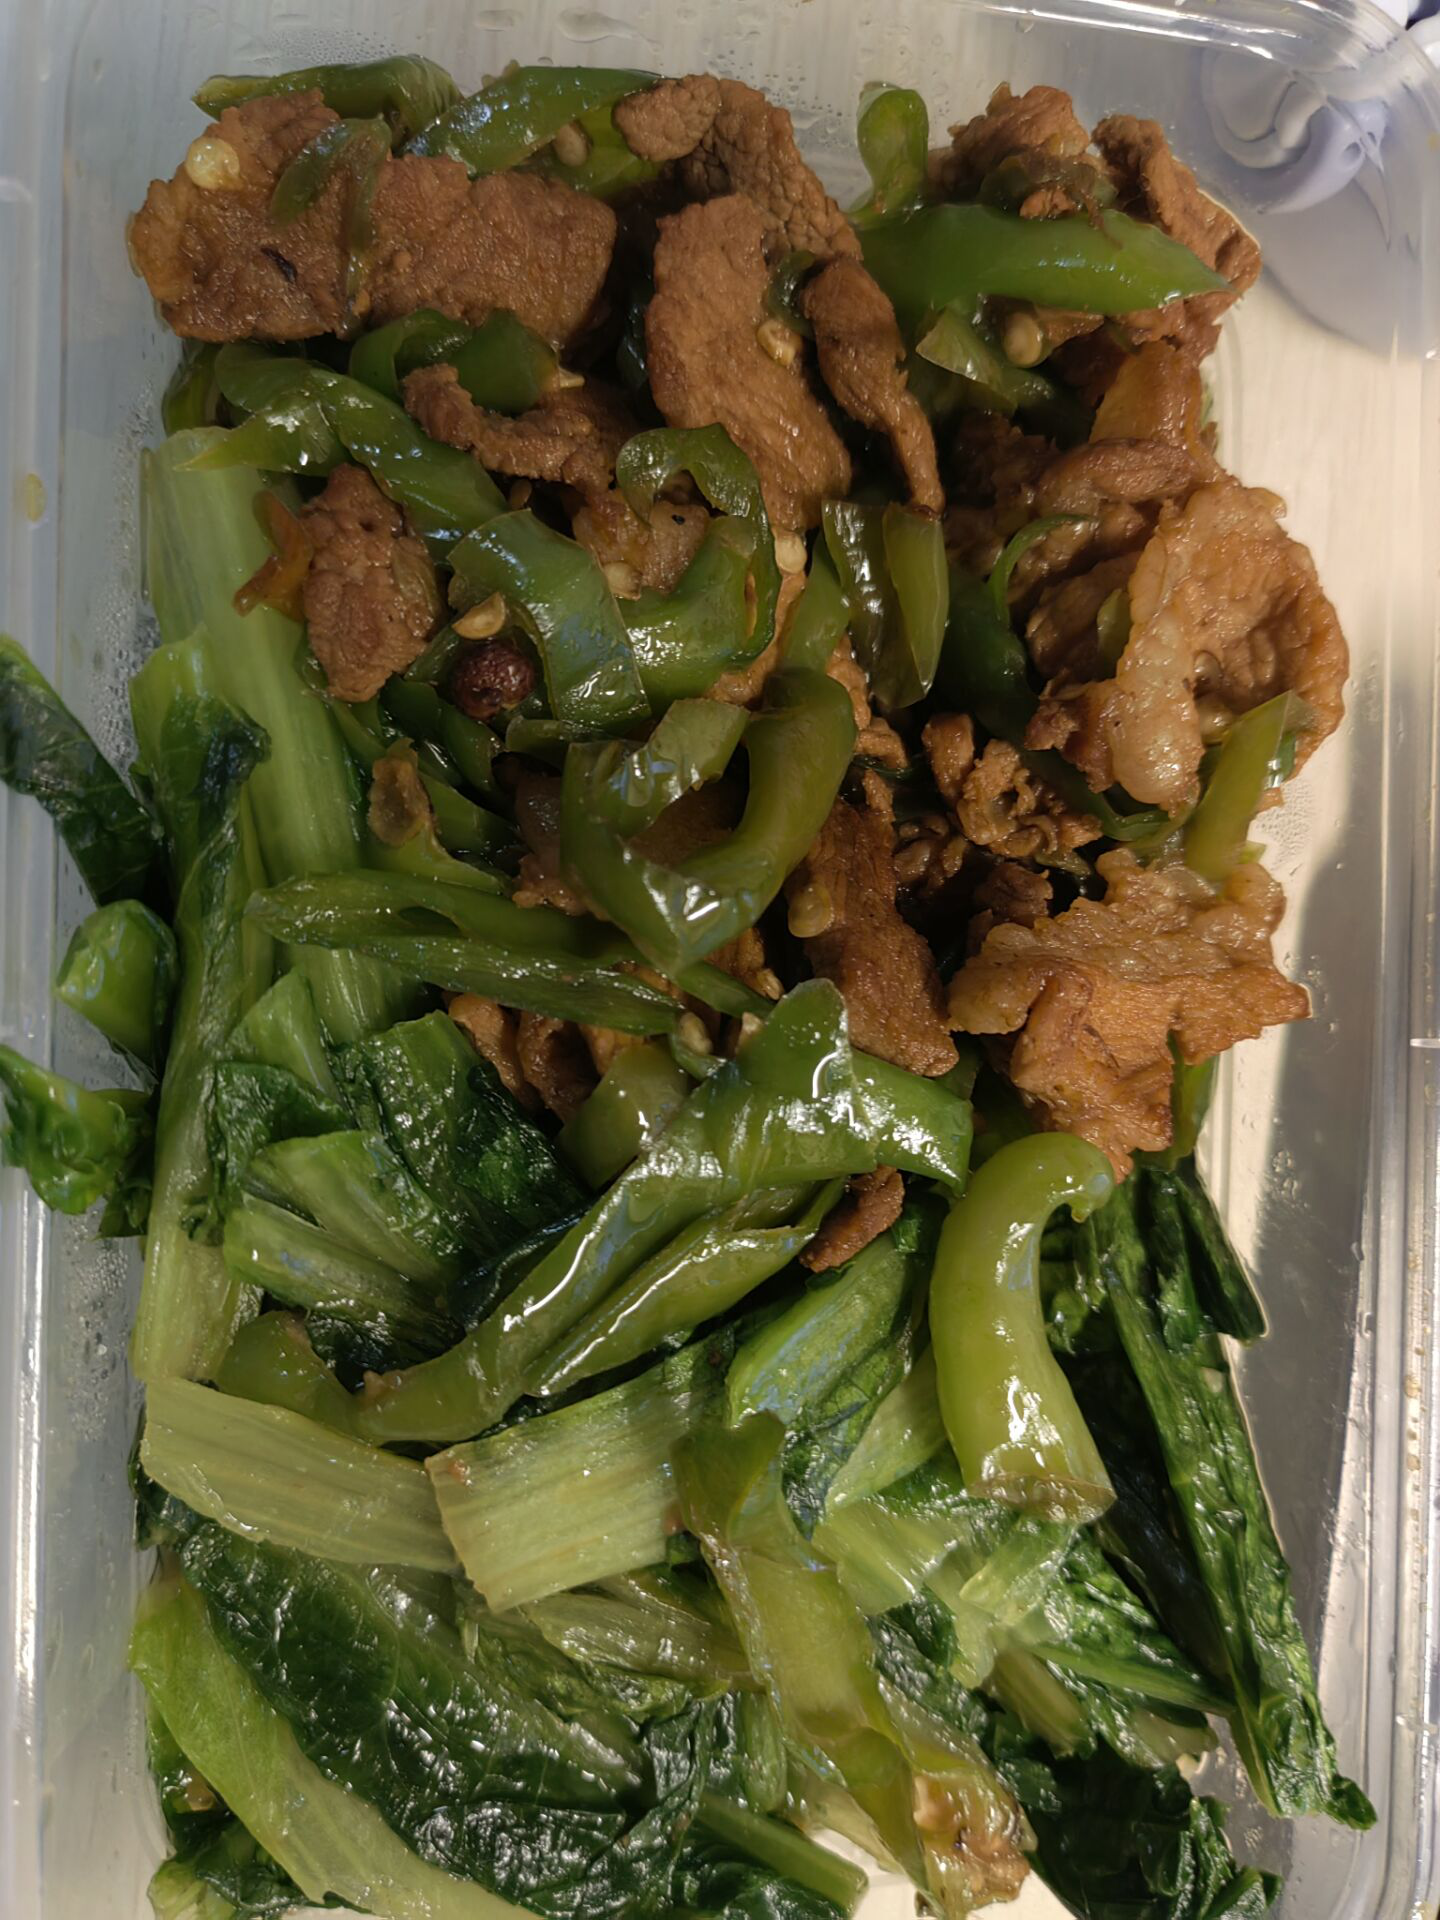

In [ ]:
import ipyplot
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
img1 = imageio.v2.imread('garbage/recyclable369.jpg')
img2 = imageio.v2.imread('garbage/harmful6.jpg')
img3 = imageio.v2.imread('garbage/kichen.jpg')
images_list=[img1,img2,img3]
labels=[b, c, a]
ipyplot.plot_images(images_list, labels=labels)

In [5]:
import torch
import torchvision
from torch.utils.mobile_optimizer import optimize_for_mobile
DEVICE = torch.device("cpu")
model = torch.load("model_mobilevit1_1.0.pth",map_location='cpu')
model.eval()
model.to(DEVICE)
example = torch.rand(1, 3, 256, 256)
traced_script_module = torch.jit.trace(model, example)
optimized_traced_model = optimize_for_mobile(traced_script_module)
optimized_traced_model._save_for_lite_interpreter("models/v3.pt")